In [6]:
from IPython.display import YouTubeVideo
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline
# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()
    
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord
    
class VideoCamera(object):
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print(self.video.isOpened())

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame

def cut_faces(image, faces_coord):
    faces = []
    
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.3 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

def resize(images, size=(50, 50)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm

def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)

<img style="float: right; margin-right: 100px" src="http://www.apulus.com/wp-content/uploads/2014/11/OpenCV-Logo.png">

<h1 style="align: center; color: ">Building the Recognition Model</h1>
<br>

Three type of models:
- Eigen Faces <br>
`cv2.face.createEigenFaceRecognizer()`
- Fisher Faces<br>
`cv2.face.createFisherFaceRecognizer()`
- LBPH Faces<br>
`cv2.face.createLBPHFaceRecognizer()`

<h2 style='color: #be2830'>Eigen Faces</h2>

- A $100 \times 100$ pixel image lies in a $10,000$ dimensional space.
- Not all dimensions are usefull
- Principal Component Analysis (PCA)
- A few dimensions account for most of the information

### How does it work?

- Finds the PCA subspace by eigenvalue decomposition: 
  - Example: Dataset of 400 images of $100 \times 100$,
  
  $S=XX^T$ where $X=10000\times 400$, 
  
  then $S=10000 \times 10000$ matrix. 
  
  Instead from linear algebra eigenvalue decomposition we take $S=X^TX$ instead. 
  
  Then recover original eigenvector by multiplying by $X$.
- Projects all training samples into the PCA subspace.
- Projects the sample image into the PCA subspace.
- Finds the nearest neighbor between the projected training images and the sample image.

<div style="float: left; width: 50%">
Reconstruction
<img style="width: 90%" src="http://docs.opencv.org/2.4/_images/eigenface_reconstruction_opencv.png">
</div>
<div style="float: right; width: 50%">
Eigenvectors
<img style="width: 100%" src="http://docs.opencv.org/2.4/_images/eigenfaces_opencv.png">
</div>
<p>Encode facial features but also illumination.</p>

<h2  style='color: #be2830'>Fisher Faces</h2>

- Eigenfaces doesn't consider any classes. 
    - Discriminative information may be lost.
    - Variance can come from external sources, such as light.
- Linear Descriminat Analysis (LDA), Sir. R. A. Fisher, 1936
- Combination of features that best separated classes.



### How does it work?

- Same classes should cluster together.
- Different classes are as far as possible from each other.
- Peforms class-specific dimensionality reduction.
- Find combination of features that best separates between classes.
- If sample number < input data dimension,  then PCA first.
 

<div style="float: left; width: 50%">
Type of Reconstruction
<img style="width: 90%" src="http://docs.opencv.org/2.4/_images/fisherface_reconstruction_opencv.png">
</div>
<div style="float: right; width: 50%">
Fisher Eigenvectors
<img style="width: 90%" src="http://docs.opencv.org/2.4/_images/fisherfaces_opencv.png">
    
</div>
<br>
<br>


<p>Does't depend on illumination as much as eigenfaces.</p>

### Performance
<img style="width: 60%; float:right; margin-right: 20px" src="http://docs.opencv.org/2.4/_images/at_database_small_sample_size.png">
<br>
<br>
Based on a fairly easy database: AT&T Face database.

<h2 align="center" style='color: #be2830'>LBPH Faces</h2>
- Don't look at the whole image
- Describe local features
- Comparing each pixel with neighborhood
- Local Binary Patters:
<img style="margin-left: 200px" src="http://docs.opencv.org/2.4/_images/lbp.png">

<h2 align="center" style='color: #be2830'>Training the Model</h2>
```python
recognizer.train(images, labels)
```
- images: list of numpy arrays
- labels: numpy array with the labels corresponding to the images


In [7]:
def collect_dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir("people/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("people/" + person):
            images.append(cv2.imread("people/" + person + '/' + image, 
                                     0))
            labels.append(i)
    return (images, np.array(labels), labels_dic)

### Collect image data and train models

In [8]:
images, labels, labels_dic = collect_dataset()

rec_eig = cv2.face.EigenFaceRecognizer_create()
rec_eig.train(images, labels)

# # needs at least two people 
rec_fisher = cv2.face.FisherFaceRecognizer_create()
rec_fisher.train(images, labels)

rec_lbph = cv2.face.LBPHFaceRecognizer_create()
rec_lbph.train(images, labels)

print("Models Trained Succesfully")

Models Trained Succesfully


### Get a sample picture

True


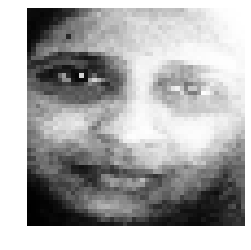

In [9]:
webcam = VideoCamera()
frame = webcam.get_frame()
detector = FaceDetector("xml/frontal_face.xml")
frame = webcam.get_frame()
faces_coord = detector.detect(frame)
faces = normalize_faces(frame, faces_coord)
face = faces[0]
plt_show(face) 

### Make Predictions with the three models

In [14]:
#collector = cv2.face.MinDistancePredictCollector()
collector = cv2.face.StandardCollector_create()
rec_eig.predict_collect(face, collector)
conf = collector.getMinDist()
pred = collector.getMinLabel()
print("Eigen Faces -> Prediction: " + labels_dic[pred].capitalize() +\
"    Confidence: " + str(round(conf)))

rec_fisher.predict_collect(face, collector)
conf = collector.getMinDist()
pred = collector.getMinLabel()
print("Fisher Faces -> Prediction: " +\
labels_dic[pred].capitalize() + "    Confidence: " + str(round(conf)))

rec_lbph.predict_collect(face, collector)
conf = collector.getMinDist()
pred = collector.getMinLabel()

print("LBPH Faces  -> Prediction: " + labels_dic[pred].capitalize() +\
"    Confidence: " + str(round(conf)))

Eigen Faces -> Prediction: Ayushi    Confidence: 1082
Fisher Faces -> Prediction: Ayushi    Confidence: 299
LBPH Faces  -> Prediction: Ayushi    Confidence: 127
